### Make More v3 — Deeper MLP with Batch Normalization and Kaiming Init

#### Initial Loss Problem
At the start of training, the model produces extremely high loss values, due to large initial logits. This happens because:

The output layer's logits are unbounded and initialized with high variance.
- This leads to large values passed into softmax → extremely confident incorrect predictions → very high cross-entropy loss.

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [4]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])  # 80% of Xtr
Xdev, Ydev = build_datasets(words[n1:n2]) # 10%
Xte, Yte = build_datasets(words[n2:]) # 10%

print(f'Xtr: {Xtr.shape}, Ytr: {Ytr.shape}')
print(f'Xdev: {Xdev.shape}, Ydev: {Ydev.shape}')
print(f'Xte: {Xte.shape}, Yte: {Yte.shape}')



Xtr: torch.Size([182594, 3]), Ytr: torch.Size([182594])
Xdev: torch.Size([22846, 3]), Ydev: torch.Size([22846])
Xte: torch.Size([22706, 3]), Yte: torch.Size([22706])


In [8]:
print(Xtr.size(), Ytr.size(), Xte.size(), Yte.size())

torch.Size([182594, 3]) torch.Size([182594]) torch.Size([22706, 3]) torch.Size([22706])


<img src="Transformers/images/img.png">

### Solution: One Way- Stabilize Initial Logits

To fix this:

```python
# Reduce scale of W2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01

# Set b1 to zeros
b1 = torch.zeros(n_hidden)
```
- In order to decrease the initial loss we need to make our initial forward pass logits close to zero.
- To make this possible (reduce the loss): we reduce W2 to a factor of 0.01 and initialize b1 to all zeros.
 This makes early outputs less extreme, aiding smoother training.</p> </div>

### Kaiming Initialization
Used
```python
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
```
This is a variant of Kaiming (He) initialization, which scales the weights according to the number of input connections (fan_in) to preserve signal variance through layers.

The general formula for Kaiming init is:
``` python
std = gain / sqrt(fan_in)
```
Where:

- fan_in is the number of input connections to the neuron

- gain depends on the activation function used


Gain for tanh Activation
For tanh activation, the recommended gain is 5/3, derived based on preserving the variance of activations through the nonlinear transformation.

#### Reference Paper
[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

### Batch Normalization
Implemented **batch normalization** to stabilize the hidden layer before applying non-linearity. This helps reduce internal covariate shift and leads to faster, more stable training.
```python
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
```
During training, the hidden layer activations hpreat are normalized like this:
``` python
bnmeani = hpreat.mean(0, keepdim=True)
bnstdi = hpreat.std(0, keepdim=True)
hpreat = bngain * (hpreat - bnmeani) / bnstdi + bnbias
```

In [9]:
n_embd = 10  # dimensionality of the character level embedding vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2323938434709) # for reproducibility
# look up table --> 2-10 (increasing embedding dim)
C = torch.rand(vocab_size, n_embd,                      generator=g)
# here (5/3)/(sqrt(fan_nodes))--- kaiming init for this weight initialization
W1 = torch.randn((n_embd*block_size, n_hidden),         generator=g)* (5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden,                              generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size),                generator=g)* 0.01
b2 = torch.randn(vocab_size,                            generator=g)* 0

# Batch Norm parameters
#--------------------------
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
#---------->># for single example input in inference----
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.zeros(1, n_hidden)
# --------------------------------------------

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Total_parameters :{sum(p.nelement() for p in parameters)}") # total num of parameters

for p in parameters:
    p.requires_grad = True

Total_parameters :12097


In [11]:
# Training a Neural Net
epochs = 200000
batch_size = 32
lossi = []

for epoch in range(epochs):
    # Mini_batch Constructor------------------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y

    # Forward pass ------------------------------------
    emb = C[Xb]  # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors

    # Linear Layer before applying Non-linearity ------------
    hpreat = embcat @ W1 #+b1 # hiden layer pre activations

    # Batch Normalization Layer ------------------------
    bnmeani = hpreat.mean(0, keepdim= True)
    bnstdi = hpreat.std(0, keepdim=True)
    hpreat = bngain *(hpreat - bnmeani)/bnstdi + bnbias # we can add E for zero division error

    # Traking  bnmean and bnstd for inference ---------
    with torch.no_grad():
        bnmean_running = 0.999* bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999* bnstd_running + 0.001*bnstdi

    # Non- Linearity ---------------------------------------
    h = torch.tanh(hpreat)  # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass ----------------------------------------
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters --------------------------------------
    # lr = lrs[i]
    lr = 0.1 if epoch < 100000 else 0.01
    for p in parameters:
        learning_rate = -lr
        p.data += learning_rate * p.grad

    # tracking status -----------------------------------------
    # lri.append(lre[i])
    if epoch % 10000 ==0:
        print(f'epoch :{epoch:7d}/{epochs:7d}: loss {loss.item():.4f}')
    #
    lossi.append(loss.log10().item())



epoch :      0/ 200000: loss 3.2824
epoch :  10000/ 200000: loss 2.5701
epoch :  20000/ 200000: loss 2.4154
epoch :  30000/ 200000: loss 2.4425
epoch :  40000/ 200000: loss 1.9790
epoch :  50000/ 200000: loss 2.4864
epoch :  60000/ 200000: loss 1.8767
epoch :  70000/ 200000: loss 1.8811
epoch :  80000/ 200000: loss 2.1519
epoch :  90000/ 200000: loss 2.2956
epoch : 100000/ 200000: loss 2.2290
epoch : 110000/ 200000: loss 1.9589
epoch : 120000/ 200000: loss 2.3025
epoch : 130000/ 200000: loss 1.5771
epoch : 140000/ 200000: loss 2.0039
epoch : 150000/ 200000: loss 2.1351
epoch : 160000/ 200000: loss 1.9827
epoch : 170000/ 200000: loss 1.6170
epoch : 180000/ 200000: loss 2.0604
epoch : 190000/ 200000: loss 1.8893


---
#### Why Track Running Mean and Std?
During inference (e.g., generating one name at a time), we no longer have a batch to compute batch statistics from. So we use running estimates of mean and standard deviation collected during training.

To do this, we maintain:
``` python
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running  = torch.ones(1, n_hidden)
```
And update them during training like this (inside the training loop):
``` python
bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
bnstd_running  = 0.999 * bnstd_running  + 0.001 * bnstdi
```
This is exponential moving average (EMA), where:

0.999 is the decay rate (you keep most of the previous value)

0.001 is the update rate from the current batch



#### Two Ways to Track Running Stats
Method 1: Track Inside Training Loop (Recommended)
- Update running statistics on each minibatch, during training

Method 2: Compute After Training (One Pass Over Full Training Set)
- If you forgot to track running stats, you can compute them once after training by running the model over the entire training dataset and accumulating the mean and std.

---

## 🧠 Visualizing Dead Neurons in `tanh` Layer

The following plot helps **identify "dead cells" or inactive neurons** in the network after applying the `tanh` activation function:


What This Plot Shows
- Each row corresponds to a different input sample (minibatch).

- Each column corresponds to a different neuron in the hidden layer.

- The values plotted are boolean: True (white) if |tanh(h)| > 0.99, False (black) otherwise.

- A white square indicates that a neuron has saturated toward +1 or -1.

What’s the Problem?
When a neuron’s activation output consistently hits the saturation points of the tanh function (+1 or -1), its gradient becomes nearly zero. This means:

- The neuron stops learning because there's no meaningful gradient signal.

- We call this phenomenon a "dead cell" or "dead neuron".

- If this persists across training samples, the neuron becomes effectively useless to the network.

How to Interpret the Plot
If a vertical white line is visible (especially one that appears across all rows), it indicates a dead neuron.

For example, if every ~30th column shows a white line, that suggests that every 30th neuron is saturating across the minibatch.

- This might be caused by:

- Poor weight initialization

- Too large learning rate

- Inappropriate activation function or lack of normalization



Fix Suggestions
To avoid dead neurons:

- Use Kaiming initialization appropriate for tanh (gain = 5/3)

- Apply Batch Normalization to keep activations in a healthy range

- Monitor the training dynamics and neuron usage visually, just like in this plot

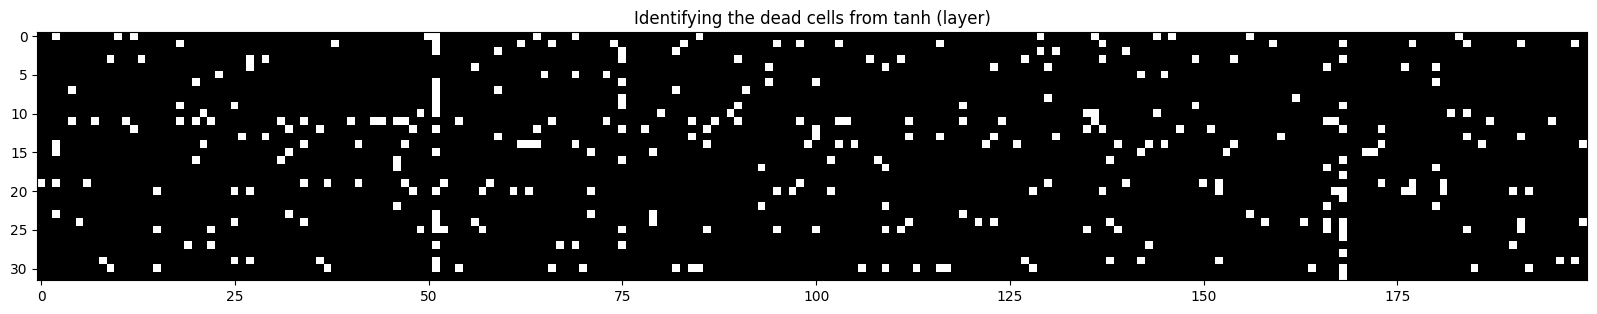

In [18]:
plt.figure(figsize=(20,10))
plt.title('Identifying the dead cells from tanh (layer)')
plt.imshow(h.abs() > 0.99, cmap="grey", interpolation="nearest");

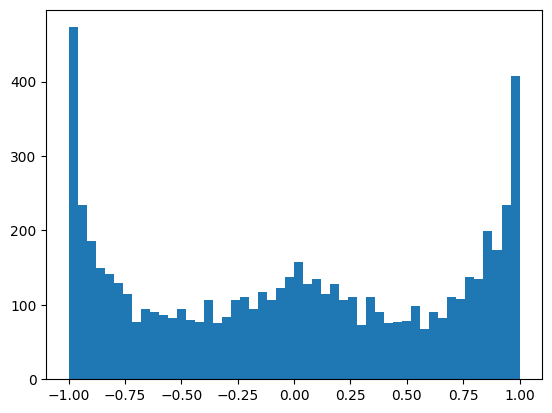

In [12]:
# distribution of activations
plt.hist(h.view(-1).tolist(), bins=50);

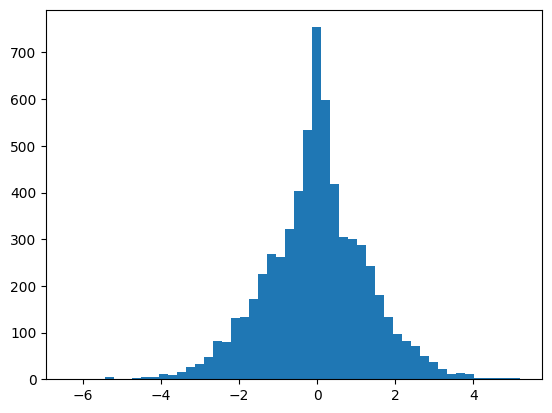

In [13]:
# distributions of weights before applying non linearity
plt.hist(hpreat.view(-1).tolist(),  bins=50);

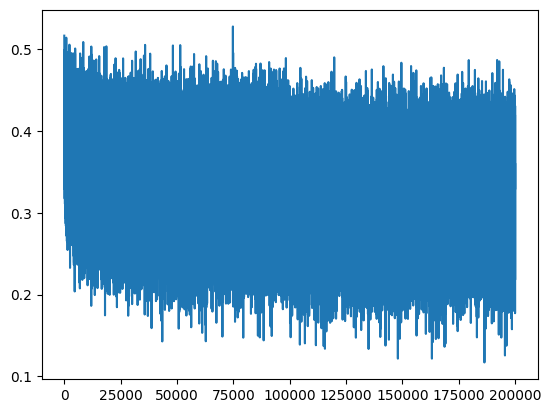

In [14]:
plt.plot(lossi)

## =========================
## Training & Val loss
## =========================

In [22]:
@torch.no_grad() # decorator helps to disable gradient traking during backward pass
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'valid' : (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreat = embcat @ W1 # + b1
    hpreat = bngain *(hpreat - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreat)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss :{loss.item()}')

split_loss("train")
split_loss("valid")

train loss :2.069355010986328
valid loss :2.1184942722320557


---

## 📊 Training Improvements Summary

We iteratively refined our model using several architectural and initialization enhancements. Below is a comparison of **training and validation loss** across different stages:

| Change Made                                       | Train Loss | Validation Loss |
|--------------------------------------------------|------------|-----------------|
| 🔹 **Original**                                   | 2.1245     | 2.1682          |
| 🔧 Fix: Softmax was confidently wrong             | 2.0750     | 2.1316          |
| 🔧 Fix: `tanh` layer too saturated at init        | 2.0697     | 2.1185          |
| 📐 Use: Semi-principled **Kaiming Initialization**| 2.0377     | 2.1070          |
| 🧪 Add: **Batch Normalization**                   | 2.0694     | 2.1185          |

---

### 🧠 Observations

- Each modification led to **gradual improvements** in train and validation loss.
- However, since we’re working with a **small dataset**, the gains are **limited and sometimes marginal**.
- **Batch normalization**, while powerful in deeper networks, may not show major benefits in this shallow architecture.




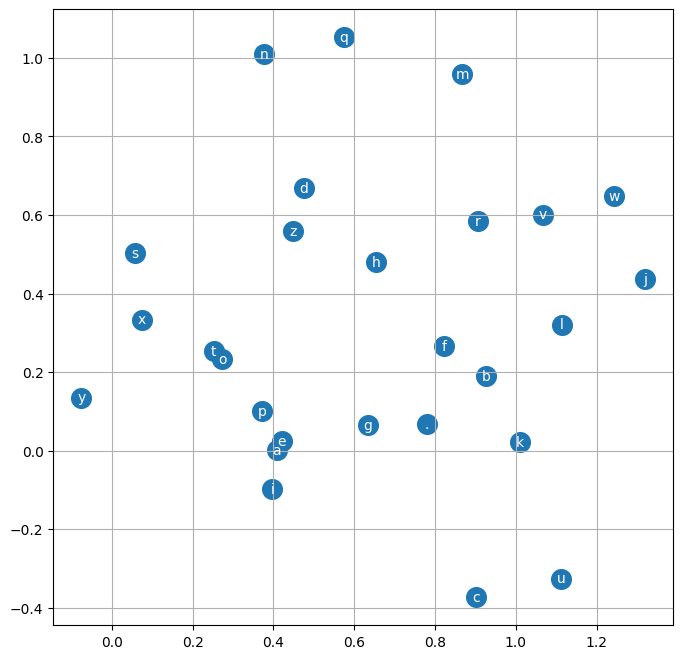

In [73]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## =========================
## Sample From the Model
## =========================

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483657)

for _ in range(20):
    out = []
    # intializing with all zeros [0,0,0] (...)
    context = [0] * block_size
    while True:
        # forward pass to the nerual network
        embed = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(embed.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sampling from the distribution using multinomial
        ix = torch.multinomial(probs, num_samples=1, generator=g)

        # shifting the context window ... ---> e ==> ..e --> m
        context = context[1:] + [ix]
        out.append(ix.item())
        # if the sample is special token (.) break
        if ix ==0:
            break
    # decoding the output embeddings
    print(''.join(itos[i] for i in out))





carmahzati.
havi.
kimrix.
taty.
hacaylie.
mahita.
deliah.
jarqui.
nellara.
chaiivon.
leigh.
ham.
pori.
quintis.
lilei.
jadiquoanthoniearynix.
kaelishuat.
emme.
iia.
gian.


---

### 🚀 Future Directions

To unlock further improvements:

- 📈 **Build a deeper MLP** with more hidden layers.
- 🔁 **Increase the context size** (block size) to capture longer character dependencies.
- 💾 Train on **larger datasets** to better leverage the capacity of the network.

Even though progress appears incremental, these tuning steps set up a robust foundation for **scaling the model** further.

---